# Final Project Title Here
### Subtitle Here

Mark Keller<br>
CMSC320<br>
Final Tutorial Project<br>
29 November 2018

#### Table of Contents
1. [Introduction](#introduction)
2. [Data](#data)
3. Exploration
4. Regression Analysis
5. Classification Analysis
6. Conclusions
7. Caveats


## Introduction

For the past few weeks, the Camp Fire in Northern California has been a deadly and destructive force, recieving enormous media coverage. 
This deadly wildfire that began on November 8, 2018 has left [85 people dead, 249 missing, and destroyed thousands of buildings](https://www.usatoday.com/story/news/nation/2018/11/25/california-wildfire-camp-fire-contained/2107829002/).
It has resulted in major air quality issues, causing many to [wear masks](https://www.washingtonpost.com/nation/2018/11/17/behold-latest-sign-apocalypse-air-mask-selfies-fire-ravaged-california/?utm_term=.fe6d94c1991f) or [stay indoors](https://www.wired.com/story/smoke-from-wildfires-is-a-growing-public-health-crisis-for-cities/) to protect their health.
But this is not the first time a major wildfire has ravaged the west coast of the United States.

In this tutorial, we will analyze west coast wildfire data from 2010 to 2016, available through the University of California Irvine Data Science Initiative GitHub organization [here](https://github.com/UCIDataScienceInitiative/Climate_Hackathon/tree/master/west_coast_fires). This data has been obtained through the NASA [Moderate Resolution Imaging Spectroradiometer](https://en.wikipedia.org/wiki/Moderate_Resolution_Imaging_Spectroradiometer) (MODIS) satellite. We will begin by loading the data and performing exploratory data analysis before diving deeper into regression analysis and classification analysis using basic machine learning methods. These data science methods will allow us to look at past trends and make inferences about future west coast wildfires.

<img src="https://www.fs.usda.gov/Internet/FSE_MEDIA/stelprdb5173318.jpg" alt="Wildfire Prevention" width="300"/>

## Data

We will begin by importing Python packages that will help us to load and wrangle the data:
- `pandas`: a package that allows us to build data frames, a tabular data format that can be thought of like a spreadsheet
- `numpy`: a package containing matrix and vector mathematical functions

In [1]:
import pandas as pd
import numpy as np

The wildfire dataset is contained in a comma-separated values file (CSV) located on GitHub. Pandas has a `read_csv` function that allows us to load a data frame from a CSV over the web. We will specify the data types of each column using a python `dict` to ensure that pandas loads the data using the data types that we will want to use in our analysis.

In [2]:
data_url = 'https://raw.githubusercontent.com/UCIDataScienceInitiative/Climate_Hackathon/master/west_coast_fires/fires.csv'
dtype = {
    'confidence': float,
    'day': int,
    'frp': float,
    'lat': float,
    'lon': float,
    'month': int,
    'year': int,
    'x': float,
    'y': float,
    'dayofyear': int,
    'vdp': float,
    'temp': float,
    'humidity': float
}
df = pd.read_csv(data_url, index_col=0, dtype=dtype)
df.head()

,confidence,day,frp,lat,lon,month,year,x,y,dayofyear,vpd,temp,humidity
id,,,,,,,,,,,,,
10122,0.61,1,6.0,32.997,-110.765,1,2010,1336.853783,110.667,0,0.232254,271.10,55.8
10123,0.72,1,11.1,32.995,-110.777,1,2010,1335.747633,110.445,0,0.232254,271.10,55.8
13460,0.57,2,6.3,33.650,-113.735,1,2010,1056.936097,183.150,1,0.333371,272.70,43.6
13461,0.62,2,10.2,32.358,-114.922,1,2010,950.464277,39.738,1,0.158511,274.70,76.8
22139,0.56,3,14.4,33.415,-110.860,1,2010,1325.030866,157.065,2,0.159304,268.62,63.5


The next step is to determine what this wildfire data means so that we can perform exploration. 
Luckily, the [README](https://github.com/UCIDataScienceInitiative/Climate_Hackathon/blob/master/west_coast_fires/README.md) for the GitHub repository provides us with a description of each column:

- `id`: unique identifier of the fire in the overall context of the world dataset
- `confidence`: how much confidence the satellite has that this is actually a fire detection (percent)
- `day`: the day of the month
- `frp`: Fire Radiative Power, the strength of the fire
- `lat`: latitude
- `lon`: longitude
- `month`: month of the year
- `year`: year
- `x`: x position in a uniformly-spaced grid
- `y`: y position in a uniformly-spaced grid
- `dayofyear`: day of the year (from 0 to 364 or 365 for leap years)
- `vpd`: [Vapor Pressure Deficit](https://en.wikipedia.org/wiki/Vapour-pressure_deficit), the difference between the moisture in the air and the amount of moisture the air could hold
- `temp`: temperature (degrees Kelvin)
- `humidity`: humidity (percent)


## Exploration

To begin our exploration, we can look at the distributions of some of our variables. 

To visualize data, we can load helpful python visualization packages:
- `matplotlib`
- `seaborn`

In [106]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

First we will look at the distribution of the confidence variable. This variable represents how confident we are that the satellite has correctly classified a specific image as a wildfire. This distribution will give us some insight into how much we can trust the results of our analysis.

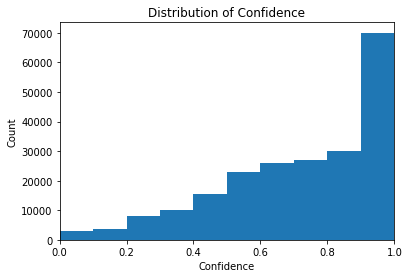

In [107]:
_ = plt.title("Distribution of Confidence")
_ = plt.xlabel("Confidence")
_ = plt.ylabel("Count")
_ = plt.xlim(0.0, 1.0)
_ = plt.hist(df['confidence'].values)

This distribution of confidence is left-skewed and its mode seems to lie between 0.9 and 1.0. Based on this distribution, it looks like we can be confident in our analysis that the majority of our data points truly represent wildfires.

Next, we can look at the Fire Radiative Power variable's distribution to get a sense of how strong fires were between 2010 and 2016.

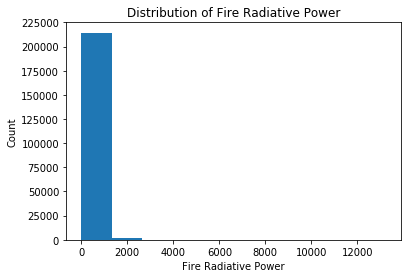

In [108]:
_ = plt.title("Distribution of Fire Radiative Power")
_ = plt.xlabel("Fire Radiative Power")
_ = plt.ylabel("Count")
_ = plt.hist(df['frp'].values)

This plot is not very helpful. We can tell that the overwhelming amount of our data points come from fires with low FRP values, but there are clearly some outliers that are not visible on this plot. Perhaps if we log scale the y-axis it will be more informative.

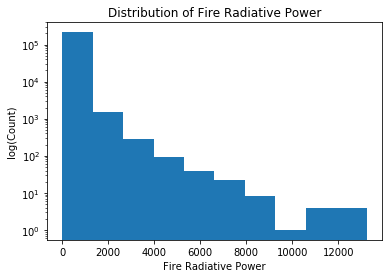

In [109]:
_ = plt.title("Distribution of Fire Radiative Power")
_ = plt.xlabel("Fire Radiative Power")
_ = plt.ylabel("log(Count)")
_ = plt.hist(df['frp'].values, log=True)

Next, we can look at the distribution over time using the `year` variable. To create this histogram we will want to bin by year rather than allowing matplotlib to choose the bins automatically, so we can use pandas `groupby` to get the counts per year explicitly:

In [124]:
year_df = df.groupby(['year']).size().reset_index(name='count')
year_df.head()

,year,count
0,2010,14951
1,2011,19262
2,2012,50917
3,2013,30635
4,2014,27831


Note that now that we have the explicit counts we can use the matplotlib `bar` rather than `hist`.

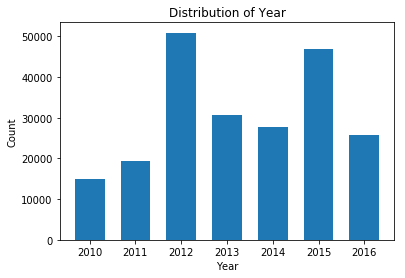

In [126]:
_ = plt.title("Distribution of Year")
_ = plt.xlabel("Year")
_ = plt.ylabel("Count")
_ = plt.bar(year_df['year'].values, year_df['count'].values, 0.65)

Next, we can look at the distribution over the year using the `dayofyear` variable.

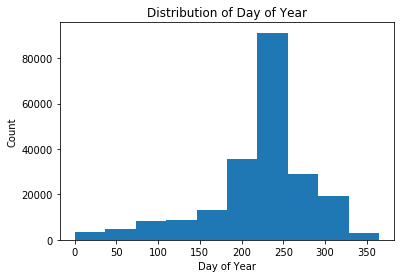

In [127]:
_ = plt.title("Distribution of Day of Year")
_ = plt.xlabel("Day of Year")
_ = plt.ylabel("Count")
_ = plt.hist(df['dayofyear'].values)

This plot shows that our distribution is fairly symmetric and unimodal, centered around day 225/365. But maybe the distribution will be more clear if we are able to view the month and day of the month variables at the same time. To do so, we will need to manipulate our data a little bit using pandas `groupby`.

In [111]:
time_df = df.groupby(['day', 'month']).size().reset_index(name='count')
time_df.head()

,day,month,count
0,1,1,26
1,1,2,177
2,1,3,98
3,1,4,318
4,1,5,313


We will need to import python's `datetime` to help with date formatting.

In [112]:
import datetime

`datetime` can be used to format our month numbers into month names by creating a date object with our month number and then specifying an output date string format that only consists of the month name.

In [113]:
def month_num_to_name(month_num):
    date = datetime.date(2018, month_num, 1)
    return date.strftime('%B')

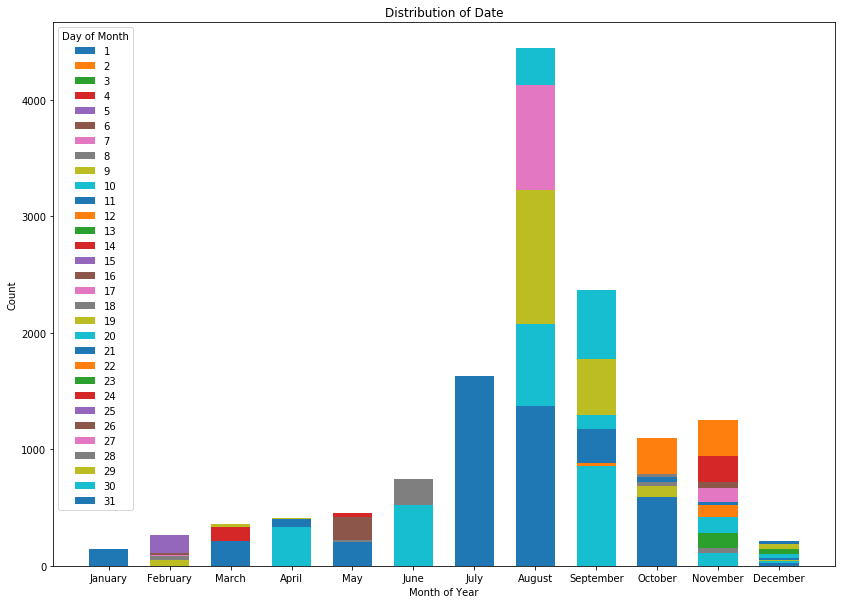

In [117]:
_ = plt.figure(figsize=(14, 10))
_ = plt.title("Distribution of Date")
_ = plt.xlabel("Month of Year")
_ = plt.ylabel("Count")
bar_width = 0.65
ax_per_day = {}
for day in time_df['day'].unique():
    day_df = time_df.loc[time_df['day'] == day].copy()
    day_df['month'] = day_df['month'].apply(month_num_to_name)
    ax_per_day[day] = plt.bar(day_df['month'].values, day_df['count'].values, bar_width)
    
_ = plt.legend([ax[0] for ax in ax_per_day.values()], ax_per_day.keys(), title="Day of Month", loc='upper left')

Finally we can look at the entire span of time from 2010 to 2016 and count the fires observed each month.

In [131]:
year_month_df = df.groupby(['year', 'month']).size().reset_index(name='count')
year_month_df['year-month'] = year_month_df.apply(lambda row: ("%s %i" % (month_num_to_name(row['month']), row['year'])), axis='columns')
year_month_df.head()

,year,month,count,year-month
0,2010,1,161,January 2010
1,2010,2,195,February 2010
2,2010,3,811,March 2010
3,2010,4,851,April 2010
4,2010,5,542,May 2010


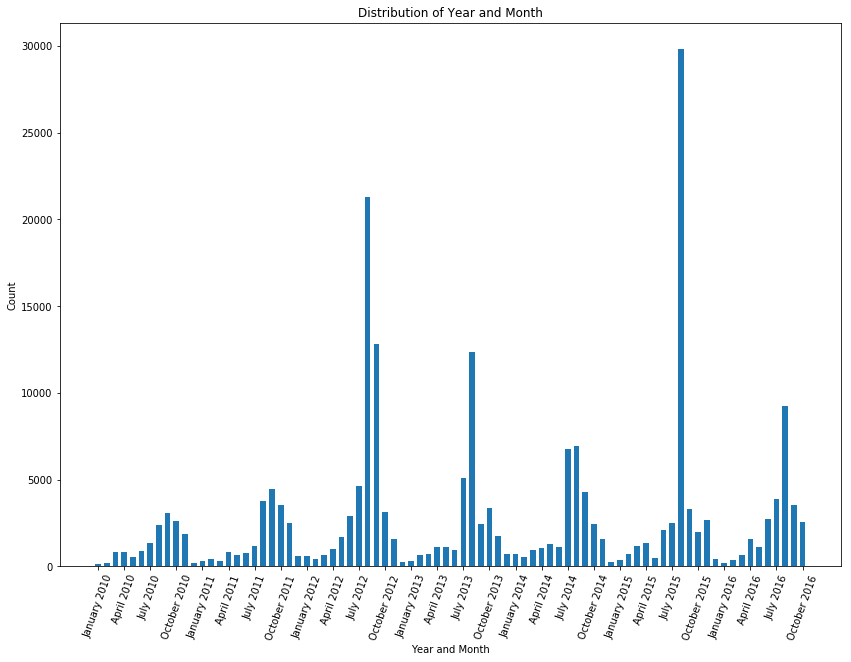

In [141]:
_ = plt.figure(figsize=(14, 10))
_ = plt.title("Distribution of Year and Month")
_ = plt.xlabel("Year and Month")
_ = plt.ylabel("Count")
_ = plt.bar(year_month_df['year-month'].values, year_month_df['count'].values, 0.65)
_ = plt.xticks(year_month_df['year-month'].values[::3], rotation=70)